In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torchsummary import summary
from collections import OrderedDict

In [2]:
cuda = torch.cuda.is_available()

# Importing data

In [42]:
batch_size = 32
valid_size = 0.2

# Data augmentation & transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Training data
trainset = datasets.MNIST(root='data', download=True, train=True, transform=transform)
#trainset = datasets.FashionMNIST(path, download=True, train=True, transform=transform)
# CIFAR10

num_train = len(trainset) # total number of data examples
indices = list(range(num_train)) # indices for each example
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train)) # split to determine training set and validation set
train_idx, valid_idx = indices[split:], indices[:split] # Indices for the training and validation set

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Creating the DataLoader for training and validation set
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
validloader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)

testset = datasets.MNIST(root='data', download=True, train=False, transform=transform)
#testset = datasets.FashionMNIST(path, download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)# Dataloader

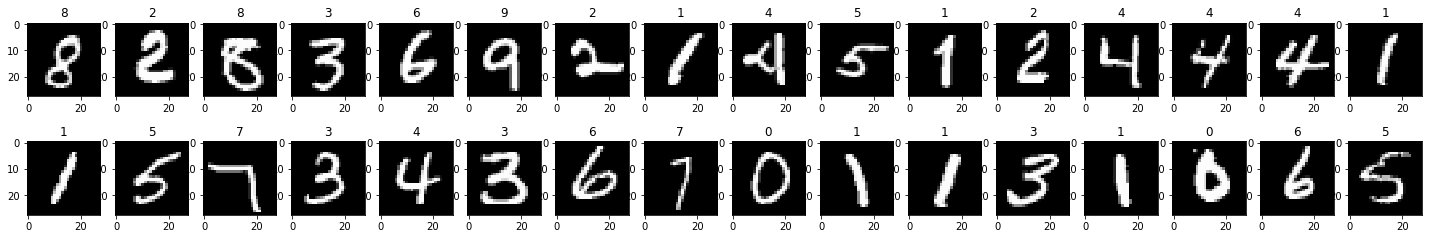

In [4]:
images, labels = next(iter(trainloader))
images = images.numpy()

fig = plt.figure(figsize=(25,4))
for i in range(32):
    ax = fig.add_subplot(2, 32/2, i+1)
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(str(labels[i].item()))

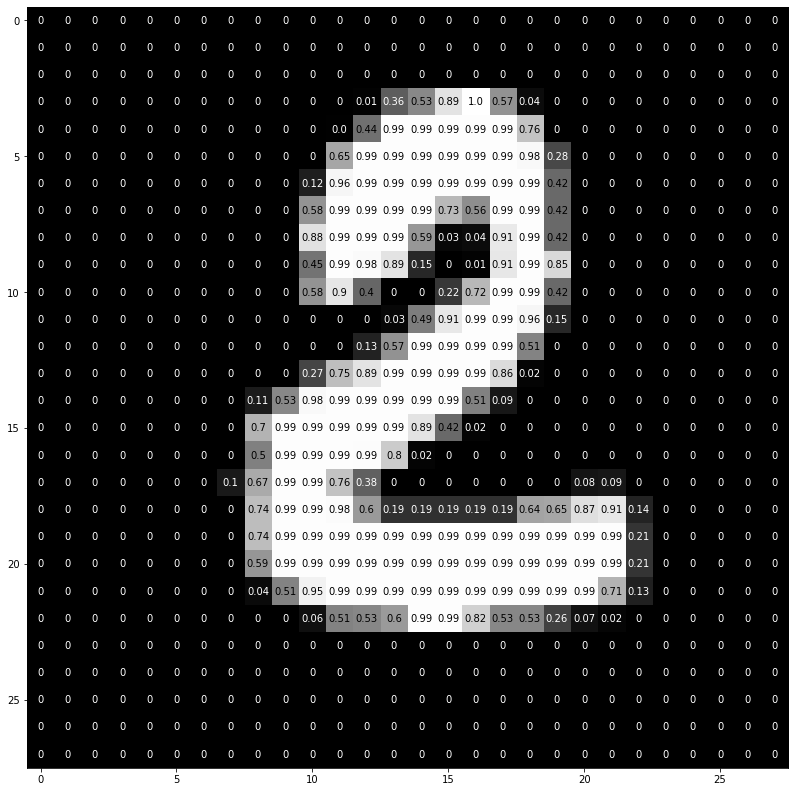

In [5]:
img = np.squeeze(images[1])

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y], 2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# MLP

In [6]:
# Module to flatten our input matrix
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [38]:
# Network Architecture
mlp_classifier = nn.Sequential(OrderedDict([
    ('flatten', Flatten()),
    ('fc1', nn.Linear(28*28,128)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(128, 10)),
    ('output', nn.LogSoftmax(dim=1))
]))

# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.01) # Define our optimizer

In [39]:
if cuda:
    mlp_classifier.cuda()

In [40]:
# Using a loop to train
epochs = 100
train_loss = []
valid_loss = []
for e in range(epochs):
    running_loss_train = 0 # training loss
    running_loss_valid = 0 # validation loss
    
    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda() # moving data to gpu
        optimizer.zero_grad() # zero out gradients

        output = mlp_classifier.forward(images) # Forward pass
        loss = criterion(output, labels) # calculate loss
        running_loss_train += loss.item()*images.size(0) # Update running training loss
        
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

    for images, labels in validloader:
        images, labels = images.cuda(), labels.cuda()
        output = mlp_classifier(images) # get output for validation set
        loss = criterion(output, labels) # calculate loss of validation set
        running_loss_valid += loss.item()*images.size(0) # update running validation loss
        
    valid_loss.append(running_loss_valid)
    train_loss.append(running_loss_train)
    
    '''
    Add a variable to store the minimum validation loss and save the model with the minimum validation loss
    Load that model to use subsequently
    '''
    
    print(f"Epochs: {int(e+1)}/{int(epochs)} --- Training loss: {running_loss_train/len(trainloader)} --- Validation loss: {running_loss_valid/len(validloader)}")


Epochs: 1/100 --- Training loss: 8.06281750459969 --- Validation loss: 7.046932770967484
Epochs: 2/100 --- Training loss: 5.280805771277596 --- Validation loss: 6.067839604943991
Epochs: 3/100 --- Training loss: 4.815652296720073 --- Validation loss: 5.610086461156607
Epochs: 4/100 --- Training loss: 4.092419706203664 --- Validation loss: 8.451745747193694
Epochs: 5/100 --- Training loss: 3.892987891143188 --- Validation loss: 7.584557700205284
Epochs: 6/100 --- Training loss: 3.5685104825347276 --- Validation loss: 8.341993186026812
Epochs: 7/100 --- Training loss: 3.453917099704408 --- Validation loss: 8.037094276964664
Epochs: 8/100 --- Training loss: 3.3382088693938763 --- Validation loss: 7.5263454343900085
Epochs: 9/100 --- Training loss: 3.0916877736218726 --- Validation loss: 8.796210497350645
Epochs: 10/100 --- Training loss: 3.178770942809062 --- Validation loss: 9.520316819598277
Epochs: 11/100 --- Training loss: 2.9694086947519778 --- Validation loss: 9.159205874567231
Epoc

Epochs: 91/100 --- Training loss: 1.5483176916178263 --- Validation loss: 52.446127572826654
Epochs: 92/100 --- Training loss: 1.4912812939553168 --- Validation loss: 53.89340116729551
Epochs: 93/100 --- Training loss: 1.2326813842272397 --- Validation loss: 50.670806035092994
Epochs: 94/100 --- Training loss: 1.551667549442422 --- Validation loss: 60.151417115539836
Epochs: 95/100 --- Training loss: 1.9116712758516707 --- Validation loss: 52.708245174991944
Epochs: 96/100 --- Training loss: 1.2192410590016085 --- Validation loss: 61.45612042578118
Epochs: 97/100 --- Training loss: 1.8412901049469952 --- Validation loss: 55.635069240592536
Epochs: 98/100 --- Training loss: 1.1498161941511054 --- Validation loss: 57.933099045708
Epochs: 99/100 --- Training loss: 1.5626638572188862 --- Validation loss: 60.94364412226788
Epochs: 100/100 --- Training loss: 1.8086108597335657 --- Validation loss: 60.75481107763539


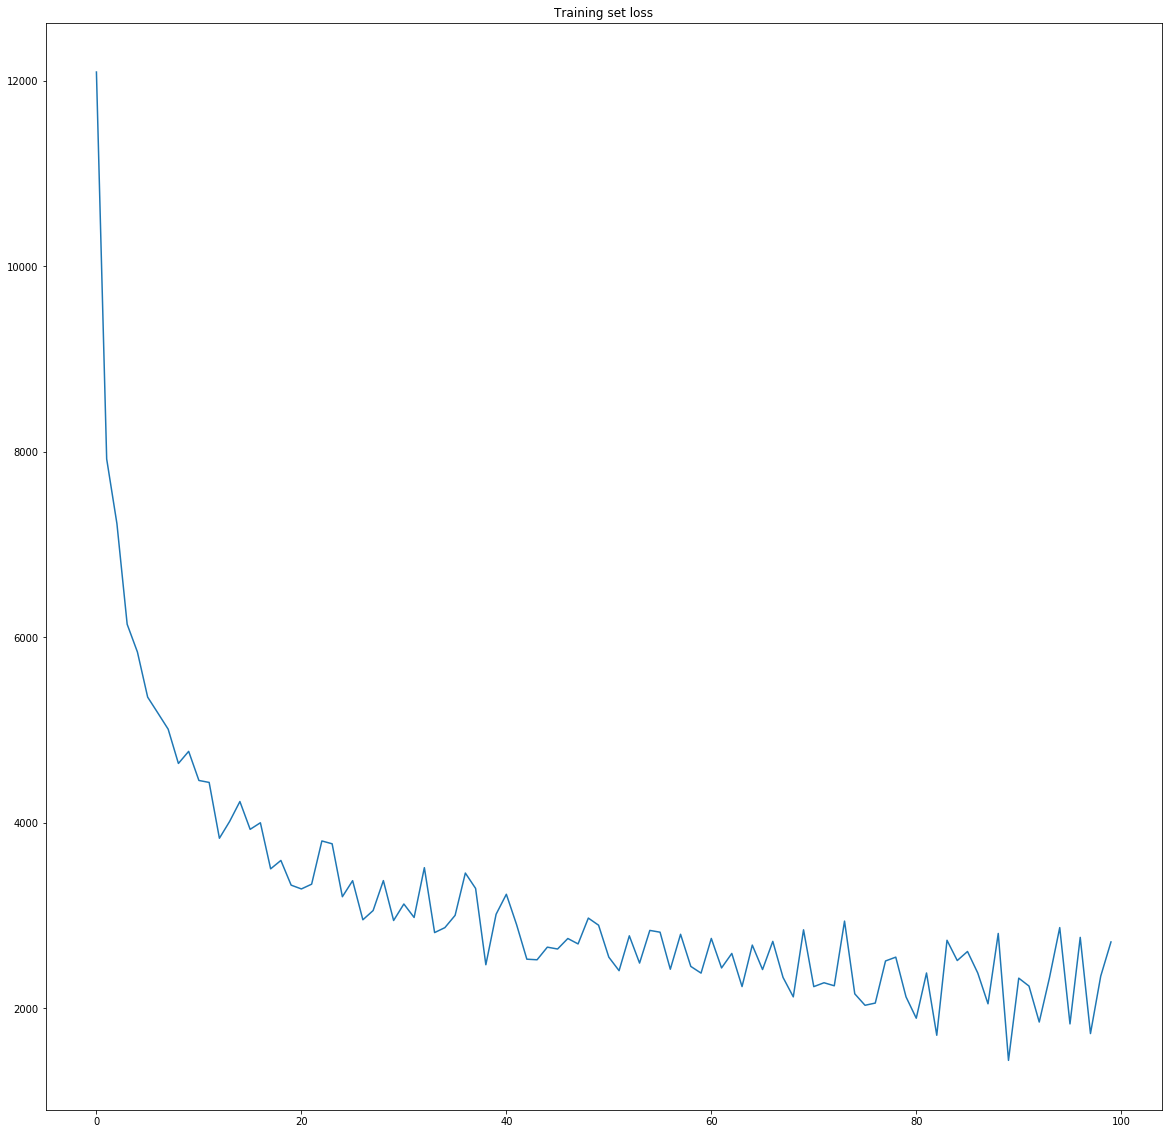

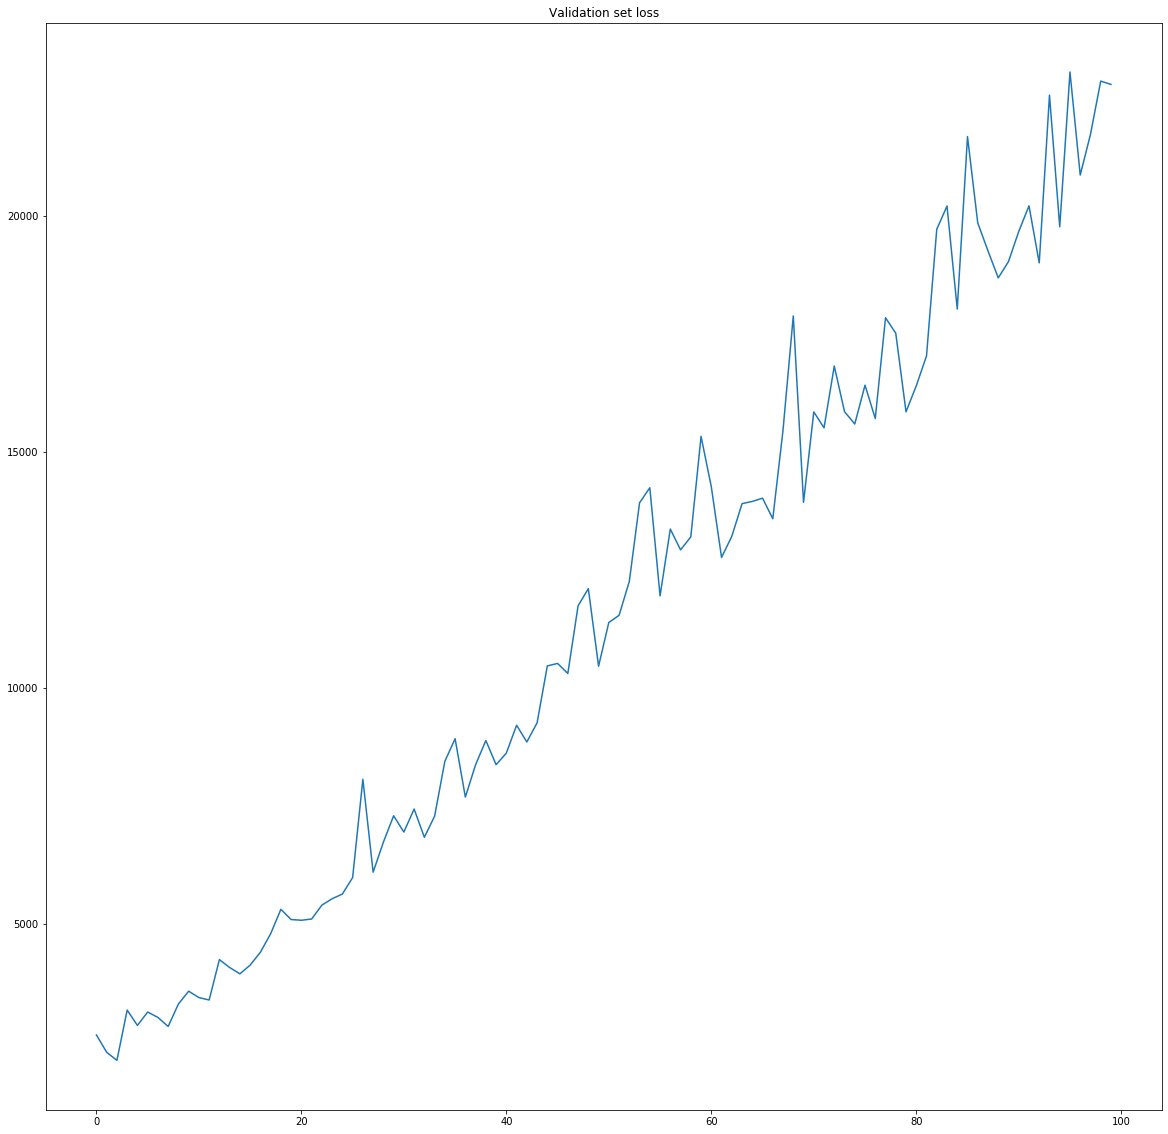

In [42]:
plt.figure(figsize=(20,20))
sns.lineplot(y=train_loss, x=range(epochs))
plt.title('Training set loss')
plt.show()

plt.figure(figsize=(20,20))
sns.lineplot(y=valid_loss, x=range(epochs))
plt.title('Validation set loss')
plt.show()

In [43]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
# 10 classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

mlp_classifier.eval() # prep model for *evaluation*. 'lock' weights

for images, labels in testloader:
    images, labels = images.cuda(), labels.cuda()
    output = mlp_classifier(images) # compute predictions
    loss = criterion(output, labels) # compute loss
    test_loss += loss.item() # update test loss

    _, pred = torch.max(output, 1) # model outputs probabilities. Convert max as the predicted class (most likely)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare y-hat with y
    # calculate test accuracy for each object class
    for i in range(images.shape[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.050529

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1125/1135)
Test Accuracy of     2: 96% (995/1032)
Test Accuracy of     3: 97% (983/1010)
Test Accuracy of     4: 96% (944/982)
Test Accuracy of     5: 95% (855/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 96% (997/1028)
Test Accuracy of     8: 95% (934/974)
Test Accuracy of     9: 96% (972/1009)

Test Accuracy (Overall): 97% (9709/10000)


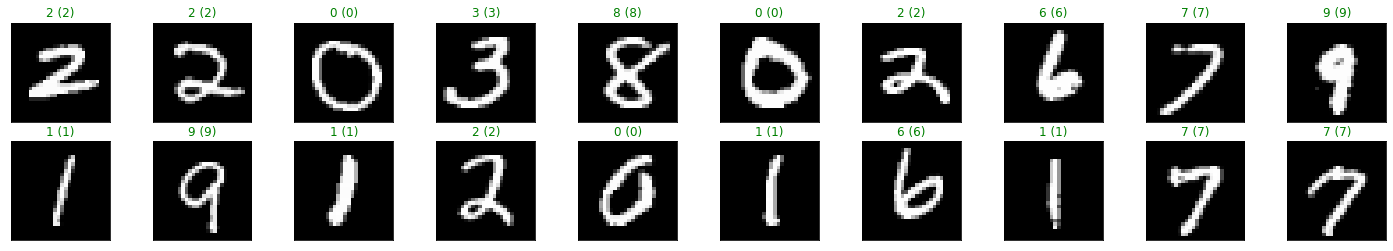

In [44]:
mlp_classifier.cpu()
# obtain one batch of test images
images, labels = next(iter(testloader))

# get sample outputs
output = mlp_classifier(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# CNN

In [52]:
# Network Architecture
cnn_classifier = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1, 16, 3, padding=1)),
    ('ReLU1', nn.ReLU()),
    ('pool1', nn.MaxPool2d(2,2)),
    ('conv2', nn.Conv2d(16, 32, 3, padding=1)),
    ('ReLU2', nn.ReLU()),
    ('pool2', nn.MaxPool2d(2, 2)),
    ('flatten', Flatten()),
    ('fc1', nn.Linear(32*7*7, 128)),
    ('ReLU3', nn.ReLU()),
    ('output', nn.Linear(128, 10)),
    ('classifier', nn.LogSoftmax(dim=1))
]))

# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_classifier.parameters(), lr=0.001) # Define our optimizer

if cuda:
    cnn_classifier.cuda()

In [53]:
summary(cnn_classifier, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
           Flatten-7                 [-1, 1568]               0
            Linear-8                  [-1, 128]         200,832
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
       LogSoftmax-11                   [-1, 10]               0
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [54]:
# Using a loop to train
epochs = 20
train_loss = []
valid_loss = []
min_valid_loss = np.inf

for e in range(epochs):
    running_loss_train = 0 # training loss
    running_loss_valid = 0 # validation loss
    
    for images, labels in trainloader:
        images, labels = images.cuda(), labels.cuda() # moving data to gpu
        optimizer.zero_grad() # zero out gradients

        output = cnn_classifier.forward(images) # Forward pass
        loss = criterion(output, labels) # calculate loss
        running_loss_train += loss.item()*images.size(0) # Update running training loss
        
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

    for images, labels in validloader:
        images, labels = images.cuda(), labels.cuda()
        output = cnn_classifier(images) # get output for validation set
        loss = criterion(output, labels) # calculate loss of validation set
        running_loss_valid += loss.item()*images.size(0) # update running validation loss
        
    # Store loss for this epoch    
    valid_loss.append(running_loss_valid)
    train_loss.append(running_loss_train)
    
    # Compute loss
    running_loss_train = running_loss_train/len(trainloader)
    running_loss_valid = running_loss_valid/len(validloader)

    print(f"Epochs: {int(e+1)}/{int(epochs)} --- Training loss: {running_loss_train} --- Validation loss: {running_loss_valid}")
    
    if running_loss_valid <= min_valid_loss:
        print(f'Validation loss decreased by {min_valid_loss - running_loss_valid}. Saving model---')
        torch.save(cnn_classifier.state_dict(), 'models/simpleCNNClassifier.pt')
        min_valid_loss = running_loss_valid

Epochs: 1/20 --- Training loss: 6.611098357230425 --- Validation loss: 2.4083975610733033
Validation loss decreased by inf. Saving model---
Epochs: 2/20 --- Training loss: 1.925005046604822 --- Validation loss: 1.48244697231551
Validation loss decreased by 0.9259505887577932. Saving model---
Epochs: 3/20 --- Training loss: 1.278122466798251 --- Validation loss: 1.305838869869709
Validation loss decreased by 0.17660810244580105. Saving model---
Epochs: 4/20 --- Training loss: 0.942187565431154 --- Validation loss: 1.8089116669464855
Epochs: 5/20 --- Training loss: 0.7519589345771819 --- Validation loss: 1.6312700236923994
Epochs: 6/20 --- Training loss: 0.592348838491928 --- Validation loss: 1.353073377640297
Epochs: 7/20 --- Training loss: 0.44799464199629924 --- Validation loss: 1.4451638548007857
Epochs: 8/20 --- Training loss: 0.40605592202981644 --- Validation loss: 1.7098054876299575
Epochs: 9/20 --- Training loss: 0.31974690862332256 --- Validation loss: 1.7886359621229737
Epochs

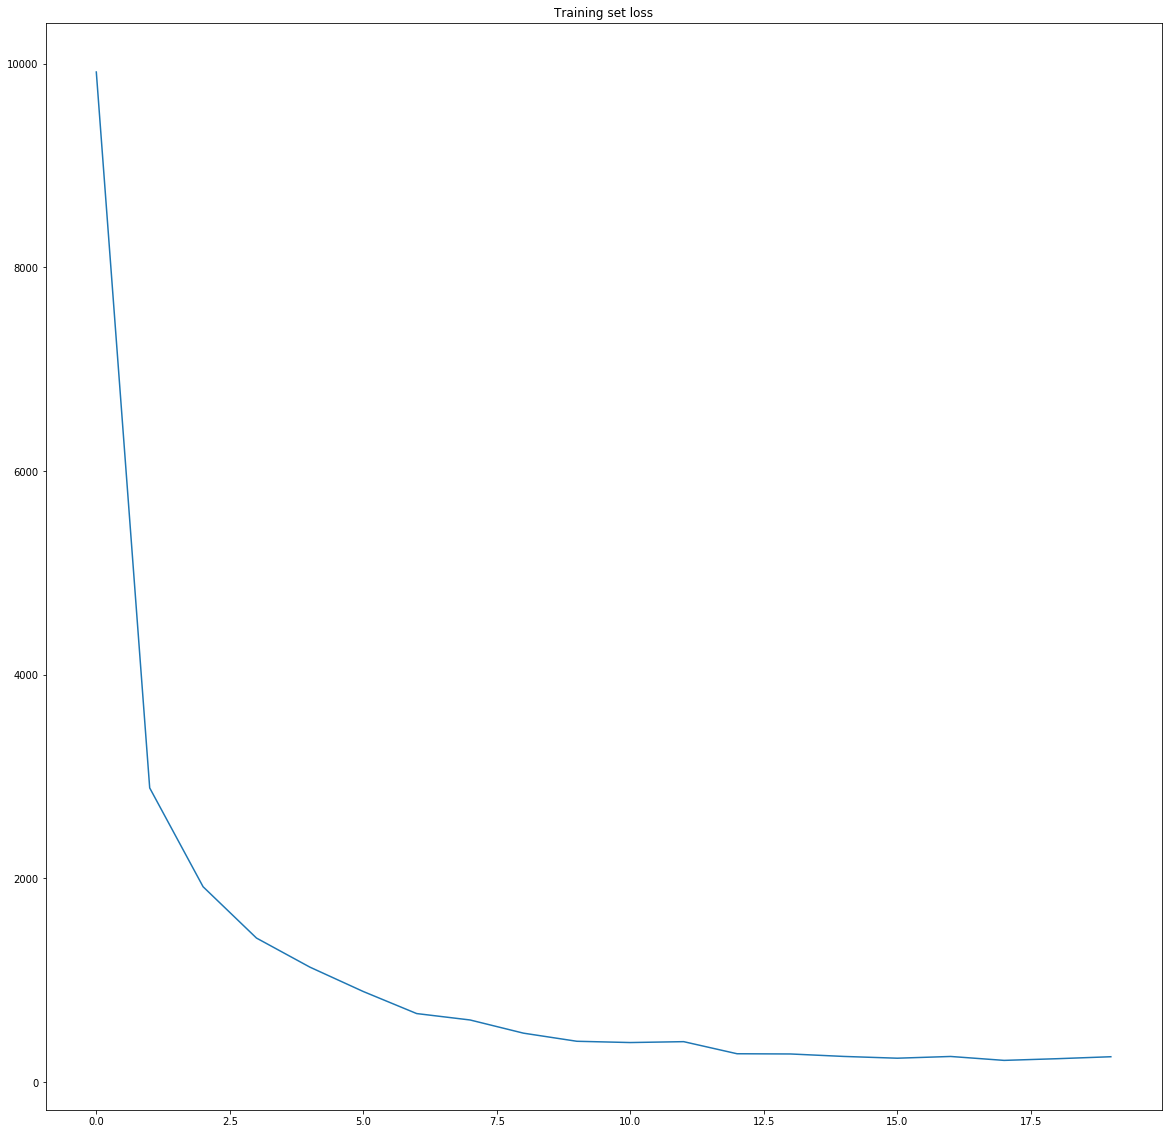

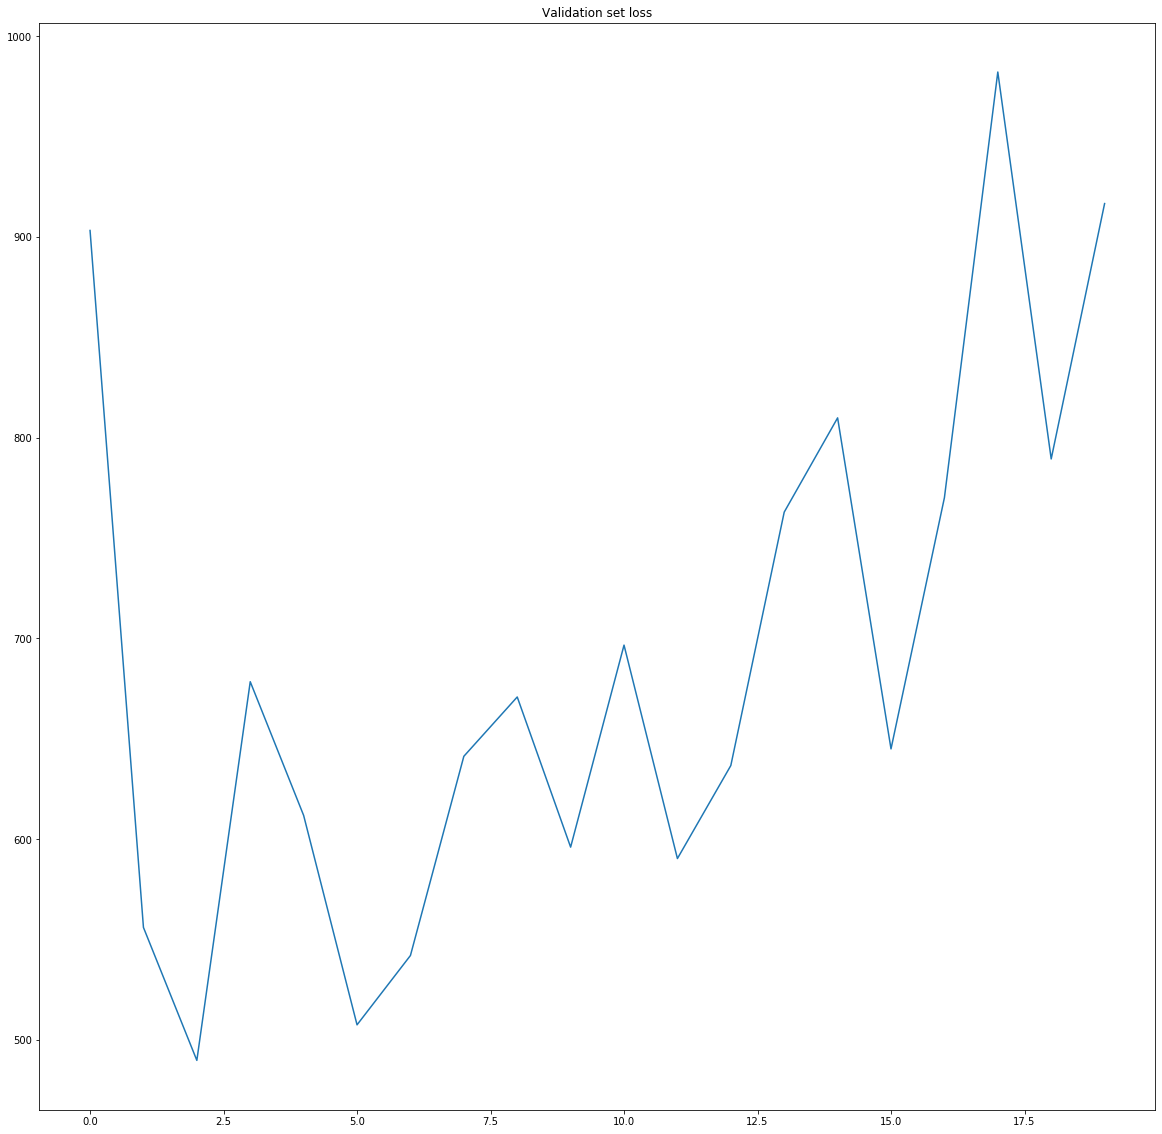

In [55]:
# Plot training loss
plt.figure(figsize=(20,20))
sns.lineplot(y=train_loss, x=range(epochs))
plt.title('Training set loss')
plt.show()

# Plot validation loss
plt.figure(figsize=(20,20))
sns.lineplot(y=valid_loss, x=range(epochs))
plt.title('Validation set loss')
plt.show()

In [58]:
# load weights that did best on validation set
cnn_classifier.load_state_dict(torch.load('models/simpleCNNClassifier.pt'))

<All keys matched successfully>

In [61]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
# 10 classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

cnn_classifier.eval() # prep model for *evaluation*. 'lock' weights

for images, labels in testloader:
    output = cnn_classifier(images) # compute predictions
    loss = criterion(output, labels) # compute loss
    test_loss += loss.item() # update test loss

    _, pred = torch.max(output, 1) # model outputs probabilities. Convert max as the predicted class (most likely)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred))) # Compare y-hat with y
    # calculate test accuracy for each object class
    for i in range(images.shape[0]):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.001034

Test Accuracy of     0: 99% (976/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 99% (1023/1032)
Test Accuracy of     3: 99% (1005/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 98% (878/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 98% (1016/1028)
Test Accuracy of     8: 99% (966/974)
Test Accuracy of     9: 98% (989/1009)

Test Accuracy (Overall): 98% (9896/10000)


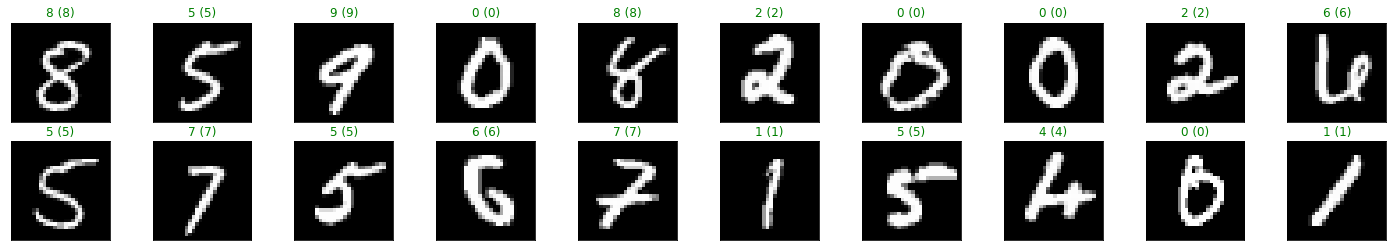

In [62]:
# obtain one batch of test images
images, labels = next(iter(testloader))

# get sample outputs
output = cnn_classifier(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))